In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

sklearn: 0.23.2
tensorflow: 2.3.1


In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Fashion MNIST dataset

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

tf.random.set_seed(42)
np.random.seed(42)

In [4]:
print ( X_train.shape )
X_train[10]

(55000, 28, 28)


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.29019608, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.05882353, 0.3254902 , 0.        , 0.        ,
        0.        , 0.00392157, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.1372549 , 0.58431373, 0.78823529,
        0.91764706, 0.83529412, 0.82745098, 0.64313725, 0.65098039,
        0.80784314, 0.89019608, 0.89411765, 0.74901961, 0.58823529,
        0.05882353, 0.        , 0.00784314, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.22352941, 0.84313725, 0.96862745, 0.93333333,
        0.88235294, 0.8627451 , 0.79607843, 0.72156863, 0.75294118,
        0.69019608, 0.7137

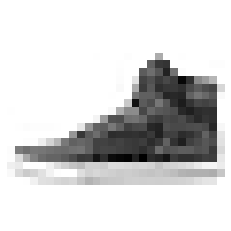

In [5]:
i_entry = 20
plt.imshow( X_train[i_entry], cmap="binary" )
plt.axis('off')
plt.show()

In [6]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
class_names[ y_train[i_entry] ]

'Sneaker'

### Scale inputs

In [7]:
X_mean = X_train.mean( axis=0 )
X_std = X_train.std( axis=0 )
X_train_scaled = ( X_train - X_mean ) / X_std
X_valid_scaled = ( X_valid - X_mean ) / X_std
X_test_scaled  = ( X_test - X_mean ) / X_std
X_train_scaled[10]

array([[-8.10756256e-03, -2.28603570e-02, -4.82088628e-02,
        -4.02934756e-02, -5.69705778e-02, -7.09606828e-02,
        -9.84522372e-02, -1.55930716e-01, -2.38698115e-01,
        -3.77802968e-01,  7.13591316e-01, -6.94190179e-01,
        -7.58510471e-01, -7.49138359e-01, -7.48505062e-01,
        -7.74760766e-01, -5.35939431e-01,  6.76180943e-01,
        -5.03267070e-01, -3.19310624e-01, -2.02581239e-01,
        -6.79116469e-02, -1.08753643e-01, -9.15151738e-02,
        -6.79206056e-02, -5.08848835e-02, -3.37408758e-02,
        -1.44791524e-02],
       [-1.20517269e-02, -1.68631769e-02, -3.29494819e-02,
        -5.55665050e-02, -7.76432672e-02, -1.31607643e-01,
        -2.43396081e-01,  3.61994118e-01,  1.78051200e+00,
         1.80178775e+00,  1.61776470e+00,  1.13037122e+00,
         9.44258605e-01,  5.13504614e-01,  5.56761075e-01,
         8.81063939e-01,  1.14789468e+00,  1.41303676e+00,
         1.30127870e+00,  1.38508262e+00, -1.88169080e-01,
        -3.16365678e-01, -1.40

### Define model build function

In [8]:
def build_model(n_hidden=1, n_neurons=50, learning_rate=5e-4, input_shape=[28,28], dropout=0.20):
    print( "Building model with:" )
    print( "Number of hidden layers: {}".format(n_hidden) )
    print( "Number of neurons per layer: {}".format(n_neurons) )
    print( "Learning rate: {}".format(learning_rate) )
    print( "Input shape: {}".format(input_shape) )
    print( "Dropout rate: {}".format(dropout) )
    
    model = keras.models.Sequential()
    model.add( keras.layers.Flatten(input_shape=input_shape) )
    for layer in range(n_hidden):
        if dropout > 0.:
            model.add( keras.layers.Dropout(rate=dropout) )
        model.add( keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal") )
    if dropout > 0.:
        model.add( keras.layers.Dropout(rate=dropout) )    
    model.add( keras.layers.Dense(10, activation="softmax") )
    
    #optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
    optimizer = keras.optimizers.Nadam(lr=learning_rate)
    model.compile( loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

### Define training callbacks

In [9]:
def get_run_logdir(log_dir):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(log_dir, run_id)

In [10]:
def callbacks(patience=10, log_dir=""):
    callbacks_ = []
    # Early stopping
    if patience > 0:
        early_stopping_cb_ = keras.callbacks.EarlyStopping( patience=patience, restore_best_weights=True )
        callbacks_.append( early_stopping_cb_ )
        
    # TensorBoard
    if log_dir:
        run_logdir = get_run_logdir(log_dir)
        print ( "Log dir: {}".format(run_logdir) )
        tensorboard_cb_ = keras.callbacks.TensorBoard( run_logdir )
        callbacks_.append( tensorboard_cb_ )
    
    return callbacks_

In [11]:
log_dir="fashion_mnist_logs"
callbacks_ = callbacks(patience=10, log_dir=log_dir)
callbacks_

Log dir: fashion_mnist_logs/run_2020_11_12-17_11_13


### Build model

In [12]:
model = build_model( 
    n_hidden=3,
    n_neurons=100,
    learning_rate=8e-4,
    input_shape=[28,28],
    dropout=0.40
    )
model.summary()

Building model with:
Number of hidden layers: 3
Number of neurons per layer: 100
Learning rate: 0.0008
Input shape: [28, 28]
Dropout rate: 0.4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)     

In [13]:
history = model.fit( X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
history.history

Epoch 1/100
   1/1719 [..............................] - ETA: 0s - loss: 5.9160 - accuracy: 0.1250WARNING:tensorflow:From /home/antoniovilela/workspace/envs/tf-gpu-py37/lib64/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1719/1719 [==============================] - 4s 3ms/step - loss: 1.2072 - accuracy: 0.6449 - val_loss: 0.4596 - val_accuracy: 0.8328
Epoch 2/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6528 - accuracy: 0.7692 - val_loss: 0.4250 - val_accuracy: 0.8438
Epoch 3/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5917 - accuracy: 0.7906 - val_loss: 0.4171 - val_accuracy: 0.8506
Epoch 4/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5531 - accuracy: 0.8037 - val_loss: 0.3891 - val_accuracy: 0.8592
Epoch 5/100
1719/1

{'loss': [1.2071599960327148,
  0.6528141498565674,
  0.5916562080383301,
  0.5531163811683655,
  0.531863808631897,
  0.5202404856681824,
  0.5078991651535034,
  0.497600257396698,
  0.4920653700828552,
  0.4802609980106354,
  0.4718872010707855,
  0.4720466136932373,
  0.469262957572937,
  0.4598357379436493,
  0.4548206925392151,
  0.4580931067466736,
  0.4520214796066284,
  0.4500926434993744,
  0.44770318269729614,
  0.4503750503063202,
  0.4441363513469696,
  0.44294026494026184,
  0.43898269534111023,
  0.4416716396808624,
  0.4356226921081543,
  0.4407561421394348,
  0.43733444809913635,
  0.43447116017341614,
  0.43634146451950073,
  0.4357619285583496,
  0.43285509943962097,
  0.433255136013031,
  0.4254980683326721,
  0.4262170195579529,
  0.433068186044693,
  0.42538467049598694],
 'accuracy': [0.6449090838432312,
  0.7692000269889832,
  0.7906363606452942,
  0.803672730922699,
  0.8116363883018494,
  0.8166909217834473,
  0.8201272487640381,
  0.824363648891449,
  0.824418

<AxesSubplot:>

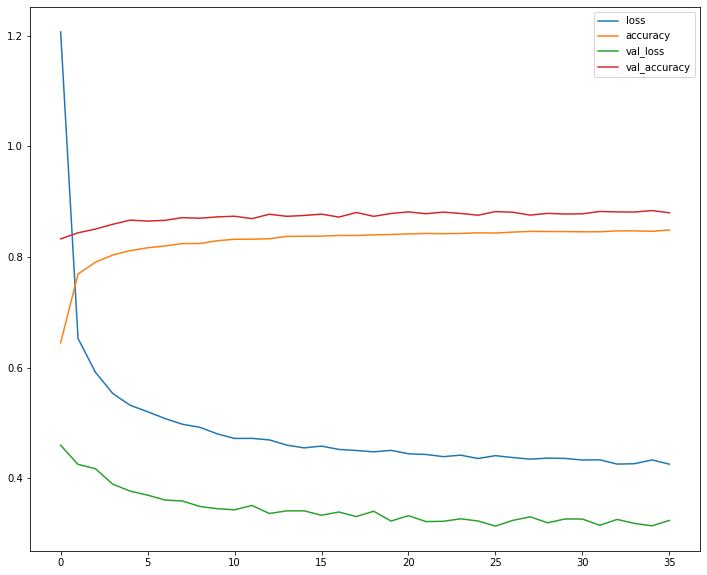

In [14]:
pd.DataFrame( history.history ).plot( figsize=(12,10) )

### Evaluate on training data (without dropout)

In [15]:
model.evaluate( X_train_scaled, y_train )

1719/1719 [==============================] - 2s 1ms/step - loss: 0.2858 - accuracy: 0.8921


[0.28584596514701843, 0.892090916633606]

### Evaluate on test data

In [16]:
model.evaluate( X_test_scaled, y_test )

313/313 [==============================] - 0s 1ms/step - loss: 0.3505 - accuracy: 0.8739


[0.3504771888256073, 0.8738999962806702]

In [17]:
y_proba = model.predict( X_test_scaled )
print ( y_proba.shape )
y_proba

(10000, 10)


array([[2.5051089e-05, 2.6564681e-05, 8.8214019e-06, ..., 1.6759995e-01,
        2.6316513e-04, 7.7944928e-01],
       [9.5630399e-05, 1.4343266e-07, 9.9409938e-01, ..., 2.6819896e-12,
        5.8884268e-07, 3.0143663e-12],
       [7.3646025e-15, 1.0000000e+00, 1.7784303e-19, ..., 2.7937077e-24,
        5.7066699e-20, 5.3353843e-25],
       ...,
       [1.0110600e-03, 9.9294248e-06, 3.2802814e-04, ..., 9.4580400e-06,
        9.9724209e-01, 2.0273756e-06],
       [2.7853091e-11, 1.0000000e+00, 6.2220431e-15, ..., 1.1188477e-18,
        2.9959102e-15, 1.1512458e-18],
       [2.9817170e-06, 8.4498339e-07, 3.8743924e-06, ..., 3.2824850e-01,
        4.9352663e-04, 5.2687887e-04]], dtype=float32)

In [18]:
i_entry_test = 10
class_names[ y_proba[ i_entry_test ].argmax() ]

'Coat'

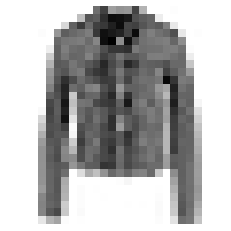

In [19]:
plt.imshow( X_test[i_entry_test], cmap="binary" )
plt.axis('off')
plt.show()

### Iterate over different learning rates

In [20]:
def find_max_learning_rate( lr_init=1e-4, lr_end=5e-2, steps=20, epochs=30, model_build_fn=build_model, *build_fn_args, **build_fn_kwargs ):
    results_ = {}
    results_['learning_rate'] = []
    results_['loss'] = []
    results_['accuracy'] = []
    results_['val_loss'] = []
    results_['val_accuracy'] = []
    c_ = (lr_end/lr_init) ** (1/steps)
    lr_ = lr_init
    for i_it in range( steps + 1 ):
        results_['learning_rate'].append( lr_ )
        model_ = model_build_fn( *build_fn_args, **build_fn_kwargs, learning_rate=lr_ )
        callbacks_ = callbacks(patience=10)
        history_ = model_.fit( X_train_scaled, y_train, epochs=epochs, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
        results_['loss'].append( history_.history['loss'] )
        results_['accuracy'].append( history_.history['accuracy'] )
        results_['val_loss'].append( history_.history['val_loss'] )
        results_['val_accuracy'].append( history_.history['val_accuracy'] )
        # Update lerning rate
        lr_ = lr_ * c_
        
    return results_

In [21]:
epochs_lr_scan=20
results = find_max_learning_rate(
            lr_init=1e-4,
            lr_end=2e-2,
            steps=10,
            epochs=epochs_lr_scan,
            model_build_fn=build_model,
            n_hidden=3,
            n_neurons=100,
            input_shape=[28,28],
            dropout=0.40
            )

Building model with:
Number of hidden layers: 3
Number of neurons per layer: 100
Learning rate: 0.0001
Input shape: [28, 28]
Dropout rate: 0.4
Epoch 1/20
1719/1719 [==============================] - 4s 3ms/step - loss: 2.4960 - accuracy: 0.4331 - val_loss: 0.6832 - val_accuracy: 0.7700
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 1.3325 - accuracy: 0.6056 - val_loss: 0.5850 - val_accuracy: 0.7918
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 1.0202 - accuracy: 0.6651 - val_loss: 0.5209 - val_accuracy: 0.8114
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8694 - accuracy: 0.7015 - val_loss: 0.4856 - val_accuracy: 0.8194
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7758 - accuracy: 0.7273 - val_loss: 0.4564 - val_accuracy: 0.8322
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7102 - accuracy: 0.7478 - val_loss: 0.4485 - val_accuracy: 

1719/1719 [==============================] - 4s 2ms/step - loss: 0.4718 - accuracy: 0.8302 - val_loss: 0.3479 - val_accuracy: 0.8694
Epoch 15/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4671 - accuracy: 0.8296 - val_loss: 0.3444 - val_accuracy: 0.8718
Epoch 16/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4620 - accuracy: 0.8313 - val_loss: 0.3439 - val_accuracy: 0.8742
Epoch 17/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4537 - accuracy: 0.8350 - val_loss: 0.3444 - val_accuracy: 0.8720
Epoch 18/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4524 - accuracy: 0.8363 - val_loss: 0.3366 - val_accuracy: 0.8764
Epoch 19/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4502 - accuracy: 0.8365 - val_loss: 0.3416 - val_accuracy: 0.8732
Epoch 20/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4430 - accuracy: 0.8415 - val_loss: 0.3318 - val_accuracy: 0.87

1719/1719 [==============================] - 4s 2ms/step - loss: 0.5347 - accuracy: 0.8136 - val_loss: 0.3659 - val_accuracy: 0.8676
Epoch 8/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5304 - accuracy: 0.8152 - val_loss: 0.3615 - val_accuracy: 0.8694
Epoch 9/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5203 - accuracy: 0.8186 - val_loss: 0.3598 - val_accuracy: 0.8696
Epoch 10/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5194 - accuracy: 0.8187 - val_loss: 0.3669 - val_accuracy: 0.8664
Epoch 11/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5154 - accuracy: 0.8189 - val_loss: 0.3593 - val_accuracy: 0.8690
Epoch 12/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5139 - accuracy: 0.8208 - val_loss: 0.3621 - val_accuracy: 0.8606
Epoch 13/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5156 - accuracy: 0.8212 - val_loss: 0.3524 - val_accuracy: 0.8692

1719/1719 [==============================] - 4s 2ms/step - loss: 1.2867 - accuracy: 0.5558 - val_loss: 0.8200 - val_accuracy: 0.6662
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 1.4654 - accuracy: 0.4943 - val_loss: 0.8384 - val_accuracy: 0.6830
Epoch 7/20
1719/1719 [==============================] - 4s 2ms/step - loss: 1.6636 - accuracy: 0.4618 - val_loss: 1.0952 - val_accuracy: 0.5848
Epoch 8/20
1719/1719 [==============================] - 4s 2ms/step - loss: 1.5724 - accuracy: 0.4388 - val_loss: 1.0222 - val_accuracy: 0.5448
Epoch 9/20
1719/1719 [==============================] - 4s 2ms/step - loss: 2.0115 - accuracy: 0.3809 - val_loss: 1.2029 - val_accuracy: 0.4656
Epoch 10/20
1719/1719 [==============================] - 4s 2ms/step - loss: 1.7776 - accuracy: 0.3680 - val_loss: 1.1685 - val_accuracy: 0.5048
Epoch 11/20
1719/1719 [==============================] - 4s 3ms/step - loss: 1.9026 - accuracy: 0.3672 - val_loss: 1.3149 - val_accuracy: 0.4114
B

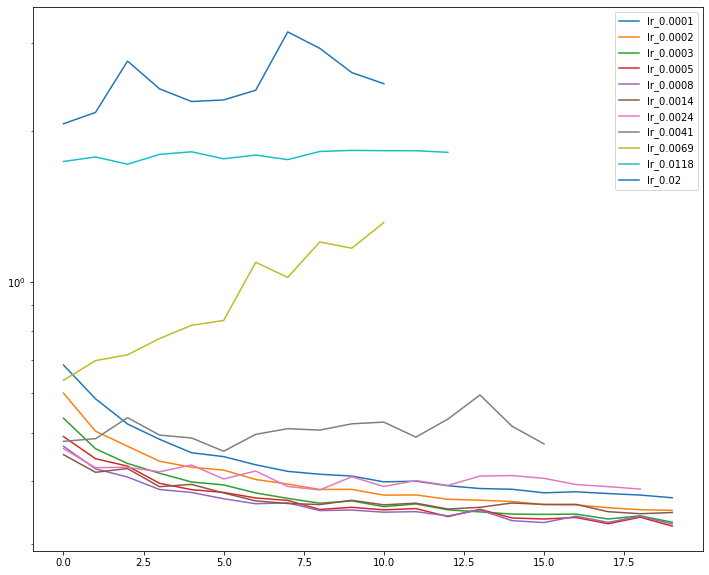

In [22]:
#pd.DataFrame( np.array( results['val_loss'] ).T,
#              columns=["lr_{}".format(lr_) for lr_ in np.round( results['learning_rate'], 4)]  ).plot( figsize=(12,10) )

metrics_ = 'val_loss'
columns=["lr_{}".format(lr_) for lr_ in np.round( results['learning_rate'], 4)] 
df = pd.DataFrame( np.full((epochs_lr_scan,len(columns)),np.nan), columns=columns )
for i_lr_,col_ in enumerate(columns):
    df[col_] = pd.Series( results[ metrics_ ][i_lr_] )
df.plot( figsize=(12,10) )
plt.yscale('log')
plt.show()

### Hyperparameter scan

In [23]:
run_grid_search = True

#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#build_fn_ = lambda n_hidden, n_neurons: build_model(n_hidden, n_neurons, learning_rate=8e-4, input_shape=[28,28], dropout=0.40)
def build_fn_(n_hidden, n_neurons):
    return build_model(n_hidden, n_neurons, learning_rate=8e-4, input_shape=[28,28], dropout=0.40)

keras_clf = keras.wrappers.scikit_learn.KerasClassifier( build_fn_ )

#param_grid = [
#    { "n_hidden": [2],
#      "n_neurons": [50,100] }
#    ]
param_grid = [
    { "n_hidden": np.arange(1,5),
      "n_neurons": [50,100] }
    ]

grid_search = GridSearchCV( keras_clf, param_grid, cv=3 )

if run_grid_search:
    callbacks_ = callbacks(patience=10)
    print ( callbacks_ )

    grid_search.fit( X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )

Building model with:
Number of hidden layers: 1
Number of neurons per layer: 50
Learning rate: 0.0008
Input shape: [28, 28]
Dropout rate: 0.4
Epoch 1/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.7894 - accuracy: 0.7345 - val_loss: 0.4484 - val_accuracy: 0.8472
Epoch 2/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.5720 - accuracy: 0.7972 - val_loss: 0.4207 - val_accuracy: 0.8486
Epoch 3/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.5229 - accuracy: 0.8109 - val_loss: 0.4039 - val_accuracy: 0.8564
Epoch 4/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.5116 - accuracy: 0.8151 - val_loss: 0.3956 - val_accuracy: 0.8612
Epoch 5/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4973 - accuracy: 0.8223 - val_loss: 0.3898 - val_accuracy: 0.8578
Epoch 6/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4852 - accuracy: 0.8240 - val_loss: 0.3881 - val_accur

1146/1146 [==============================] - 2s 2ms/step - loss: 0.4350 - accuracy: 0.8374 - val_loss: 0.3646 - val_accuracy: 0.8770
Epoch 30/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4374 - accuracy: 0.8383 - val_loss: 0.3698 - val_accuracy: 0.8754
Epoch 31/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4343 - accuracy: 0.8386 - val_loss: 0.3637 - val_accuracy: 0.8740
Epoch 32/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4302 - accuracy: 0.8408 - val_loss: 0.3672 - val_accuracy: 0.8766
Epoch 33/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4327 - accuracy: 0.8406 - val_loss: 0.3665 - val_accuracy: 0.8720
Epoch 34/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4344 - accuracy: 0.8396 - val_loss: 0.3623 - val_accuracy: 0.8762
Epoch 35/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4306 - accuracy: 0.8398 - val_loss: 0.3544 - val_accuracy

1146/1146 [==============================] - 2s 2ms/step - loss: 0.4085 - accuracy: 0.8503 - val_loss: 0.3406 - val_accuracy: 0.8810
Epoch 15/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4063 - accuracy: 0.8519 - val_loss: 0.3454 - val_accuracy: 0.8792
Epoch 16/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4026 - accuracy: 0.8514 - val_loss: 0.3465 - val_accuracy: 0.8790
Epoch 17/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4023 - accuracy: 0.8532 - val_loss: 0.3412 - val_accuracy: 0.8830
Epoch 18/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.3947 - accuracy: 0.8536 - val_loss: 0.3483 - val_accuracy: 0.8786
Epoch 19/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4020 - accuracy: 0.8528 - val_loss: 0.3396 - val_accuracy: 0.8832
Epoch 20/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.3915 - accuracy: 0.8551 - val_loss: 0.3439 - val_accuracy

1146/1146 [==============================] - 2s 2ms/step - loss: 0.3792 - accuracy: 0.8586 - val_loss: 0.3489 - val_accuracy: 0.8856
Epoch 40/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.3801 - accuracy: 0.8582 - val_loss: 0.3576 - val_accuracy: 0.8850
Epoch 41/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.3790 - accuracy: 0.8613 - val_loss: 0.3512 - val_accuracy: 0.8836
Epoch 42/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.3782 - accuracy: 0.8597 - val_loss: 0.3567 - val_accuracy: 0.8814
Epoch 43/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.3841 - accuracy: 0.8594 - val_loss: 0.3481 - val_accuracy: 0.8844
Epoch 44/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.3849 - accuracy: 0.8576 - val_loss: 0.3437 - val_accuracy: 0.8874
Epoch 45/100
573/573 [==============================] - 1s 1ms/step - loss: 0.3306 - accuracy: 0.8855
Building model with:
Number of hidd

1146/1146 [==============================] - 3s 2ms/step - loss: 0.4957 - accuracy: 0.8236 - val_loss: 0.3672 - val_accuracy: 0.8650
Epoch 20/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4941 - accuracy: 0.8234 - val_loss: 0.3567 - val_accuracy: 0.8744
Epoch 21/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4945 - accuracy: 0.8247 - val_loss: 0.3592 - val_accuracy: 0.8694
Epoch 22/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4887 - accuracy: 0.8278 - val_loss: 0.3698 - val_accuracy: 0.8684
Epoch 23/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4847 - accuracy: 0.8268 - val_loss: 0.3566 - val_accuracy: 0.8698
Epoch 24/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4866 - accuracy: 0.8266 - val_loss: 0.3526 - val_accuracy: 0.8702
Epoch 25/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4881 - accuracy: 0.8252 - val_loss: 0.3523 - val_accuracy

Epoch 32/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4779 - accuracy: 0.8259 - val_loss: 0.3615 - val_accuracy: 0.8642
Epoch 33/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4820 - accuracy: 0.8259 - val_loss: 0.3567 - val_accuracy: 0.8676
Epoch 34/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.4817 - accuracy: 0.8253 - val_loss: 0.3550 - val_accuracy: 0.8662
Epoch 35/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4765 - accuracy: 0.8286 - val_loss: 0.3525 - val_accuracy: 0.8694
Epoch 36/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.4826 - accuracy: 0.8241 - val_loss: 0.3490 - val_accuracy: 0.8734
Epoch 37/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.4767 - accuracy: 0.8276 - val_loss: 0.3563 - val_accuracy: 0.8660
Epoch 38/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4746 - accuracy: 0.8286 - val_loss: 0.3499 -

1146/1146 [==============================] - 2s 2ms/step - loss: 0.4773 - accuracy: 0.8269 - val_loss: 0.3484 - val_accuracy: 0.8690
Epoch 33/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4741 - accuracy: 0.8295 - val_loss: 0.3485 - val_accuracy: 0.8670
Epoch 34/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4727 - accuracy: 0.8309 - val_loss: 0.3473 - val_accuracy: 0.8668
Epoch 35/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4787 - accuracy: 0.8300 - val_loss: 0.3524 - val_accuracy: 0.8648
Epoch 36/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4700 - accuracy: 0.8281 - val_loss: 0.3450 - val_accuracy: 0.8680
Epoch 37/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4788 - accuracy: 0.8257 - val_loss: 0.3538 - val_accuracy: 0.8694
Epoch 38/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4771 - accuracy: 0.8294 - val_loss: 0.3428 - val_accuracy

1146/1146 [==============================] - 3s 3ms/step - loss: 0.4286 - accuracy: 0.8433 - val_loss: 0.3318 - val_accuracy: 0.8788
Epoch 23/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4285 - accuracy: 0.8440 - val_loss: 0.3267 - val_accuracy: 0.8770
Epoch 24/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4231 - accuracy: 0.8455 - val_loss: 0.3268 - val_accuracy: 0.8796
Epoch 25/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4271 - accuracy: 0.8427 - val_loss: 0.3253 - val_accuracy: 0.8808
Epoch 26/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4247 - accuracy: 0.8444 - val_loss: 0.3257 - val_accuracy: 0.8776
Epoch 27/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4280 - accuracy: 0.8452 - val_loss: 0.3288 - val_accuracy: 0.8758
Epoch 28/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4199 - accuracy: 0.8474 - val_loss: 0.3186 - val_accuracy

1146/1146 [==============================] - 3s 2ms/step - loss: 0.4131 - accuracy: 0.8465 - val_loss: 0.3127 - val_accuracy: 0.8834
Epoch 36/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4124 - accuracy: 0.8465 - val_loss: 0.3164 - val_accuracy: 0.8854
Epoch 37/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4171 - accuracy: 0.8473 - val_loss: 0.3220 - val_accuracy: 0.8784
Epoch 38/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4085 - accuracy: 0.8487 - val_loss: 0.3110 - val_accuracy: 0.8828
Epoch 39/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.4114 - accuracy: 0.8494 - val_loss: 0.3096 - val_accuracy: 0.8812
Epoch 40/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4100 - accuracy: 0.8486 - val_loss: 0.3142 - val_accuracy: 0.8828
Epoch 41/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4118 - accuracy: 0.8506 - val_loss: 0.3185 - val_accuracy

1146/1146 [==============================] - 3s 2ms/step - loss: 0.4253 - accuracy: 0.8453 - val_loss: 0.3166 - val_accuracy: 0.8826
Epoch 29/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4168 - accuracy: 0.8468 - val_loss: 0.3214 - val_accuracy: 0.8802
Epoch 30/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4186 - accuracy: 0.8469 - val_loss: 0.3122 - val_accuracy: 0.8830
Epoch 31/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4130 - accuracy: 0.8478 - val_loss: 0.3153 - val_accuracy: 0.8798
Epoch 32/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4132 - accuracy: 0.8479 - val_loss: 0.3130 - val_accuracy: 0.8814
Epoch 33/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4154 - accuracy: 0.8468 - val_loss: 0.3125 - val_accuracy: 0.8798
Epoch 34/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4089 - accuracy: 0.8492 - val_loss: 0.3170 - val_accuracy

Epoch 35/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.5016 - accuracy: 0.8280 - val_loss: 0.3652 - val_accuracy: 0.8664
Epoch 36/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4984 - accuracy: 0.8264 - val_loss: 0.3554 - val_accuracy: 0.8718
Epoch 37/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4986 - accuracy: 0.8247 - val_loss: 0.3603 - val_accuracy: 0.8692
Epoch 38/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.5006 - accuracy: 0.8273 - val_loss: 0.3551 - val_accuracy: 0.8744
Epoch 39/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.4985 - accuracy: 0.8268 - val_loss: 0.3514 - val_accuracy: 0.8756
Epoch 40/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4978 - accuracy: 0.8265 - val_loss: 0.3571 - val_accuracy: 0.8734
Epoch 41/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.5016 - accuracy: 0.8281 - val_loss: 0.3531 -

1146/1146 [==============================] - 3s 3ms/step - loss: 0.5283 - accuracy: 0.8148 - val_loss: 0.3832 - val_accuracy: 0.8586
Epoch 19/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.5316 - accuracy: 0.8135 - val_loss: 0.3877 - val_accuracy: 0.8608
Epoch 20/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.5266 - accuracy: 0.8144 - val_loss: 0.3752 - val_accuracy: 0.8620
Epoch 21/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.5245 - accuracy: 0.8178 - val_loss: 0.3818 - val_accuracy: 0.8626
Epoch 22/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.5239 - accuracy: 0.8204 - val_loss: 0.3752 - val_accuracy: 0.8656
Epoch 23/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.5248 - accuracy: 0.8166 - val_loss: 0.3713 - val_accuracy: 0.8638
Epoch 24/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.5224 - accuracy: 0.8164 - val_loss: 0.3696 - val_accuracy

1146/1146 [==============================] - 3s 3ms/step - loss: 0.4936 - accuracy: 0.8270 - val_loss: 0.3479 - val_accuracy: 0.8720
Epoch 75/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.4983 - accuracy: 0.8254 - val_loss: 0.3460 - val_accuracy: 0.8734
Epoch 76/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.4890 - accuracy: 0.8290 - val_loss: 0.3493 - val_accuracy: 0.8726
Epoch 77/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.4884 - accuracy: 0.8297 - val_loss: 0.3456 - val_accuracy: 0.8740
Epoch 78/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.4887 - accuracy: 0.8279 - val_loss: 0.3520 - val_accuracy: 0.8722
Epoch 79/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.4901 - accuracy: 0.8311 - val_loss: 0.3467 - val_accuracy: 0.8744
Epoch 80/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.4886 - accuracy: 0.8303 - val_loss: 0.3487 - val_accuracy

Epoch 47/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.4982 - accuracy: 0.8259 - val_loss: 0.3554 - val_accuracy: 0.8732
Epoch 48/100
573/573 [==============================] - 1s 2ms/step - loss: 0.3677 - accuracy: 0.8664
Building model with:
Number of hidden layers: 3
Number of neurons per layer: 100
Learning rate: 0.0008
Input shape: [28, 28]
Dropout rate: 0.4
Epoch 1/100
1146/1146 [==============================] - 3s 3ms/step - loss: 1.3887 - accuracy: 0.6060 - val_loss: 0.5055 - val_accuracy: 0.8160
Epoch 2/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.7300 - accuracy: 0.7428 - val_loss: 0.4494 - val_accuracy: 0.8334
Epoch 3/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.6331 - accuracy: 0.7741 - val_loss: 0.4365 - val_accuracy: 0.8442
Epoch 4/100
1146/1146 [==============================] - 3s 2ms/step - loss: 0.5920 - accuracy: 0.7907 - val_loss: 0.4140 - val_accuracy: 0.8490
Epoch 5/100
1146/1146 [======

1146/1146 [==============================] - 3s 2ms/step - loss: 0.4236 - accuracy: 0.8488 - val_loss: 0.3227 - val_accuracy: 0.8818
Epoch 54/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.4177 - accuracy: 0.8503 - val_loss: 0.3220 - val_accuracy: 0.8834
Epoch 55/100
1146/1146 [==============================] - 4s 3ms/step - loss: 0.4135 - accuracy: 0.8511 - val_loss: 0.3271 - val_accuracy: 0.8766
Epoch 56/100
1146/1146 [==============================] - 4s 3ms/step - loss: 0.4194 - accuracy: 0.8509 - val_loss: 0.3248 - val_accuracy: 0.8780
Epoch 57/100
1146/1146 [==============================] - 4s 3ms/step - loss: 0.4149 - accuracy: 0.8523 - val_loss: 0.3164 - val_accuracy: 0.8834
Epoch 58/100
1146/1146 [==============================] - 3s 3ms/step - loss: 0.4130 - accuracy: 0.8528 - val_loss: 0.3237 - val_accuracy: 0.8808
Epoch 59/100
1146/1146 [==============================] - 4s 3ms/step - loss: 0.4130 - accuracy: 0.8517 - val_loss: 0.3173 - val_accuracy

1146/1146 [==============================] - 4s 4ms/step - loss: 0.4539 - accuracy: 0.8370 - val_loss: 0.3482 - val_accuracy: 0.8704
Epoch 21/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.4552 - accuracy: 0.8362 - val_loss: 0.3453 - val_accuracy: 0.8696
Epoch 22/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.4487 - accuracy: 0.8388 - val_loss: 0.3522 - val_accuracy: 0.8704
Epoch 23/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4520 - accuracy: 0.8384 - val_loss: 0.3424 - val_accuracy: 0.8770
Epoch 24/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.4458 - accuracy: 0.8384 - val_loss: 0.3433 - val_accuracy: 0.8750
Epoch 25/100
1146/1146 [==============================] - 4s 3ms/step - loss: 0.4421 - accuracy: 0.8391 - val_loss: 0.3325 - val_accuracy: 0.8774
Epoch 26/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.4430 - accuracy: 0.8394 - val_loss: 0.3374 - val_accuracy

1146/1146 [==============================] - 4s 3ms/step - loss: 0.4922 - accuracy: 0.8264 - val_loss: 0.3597 - val_accuracy: 0.8660
Epoch 14/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4743 - accuracy: 0.8293 - val_loss: 0.3553 - val_accuracy: 0.8714
Epoch 15/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.4753 - accuracy: 0.8295 - val_loss: 0.3610 - val_accuracy: 0.8644
Epoch 16/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.4717 - accuracy: 0.8313 - val_loss: 0.3495 - val_accuracy: 0.8692
Epoch 17/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.4708 - accuracy: 0.8330 - val_loss: 0.3543 - val_accuracy: 0.8696
Epoch 18/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.4645 - accuracy: 0.8317 - val_loss: 0.3432 - val_accuracy: 0.8704
Epoch 19/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.4593 - accuracy: 0.8356 - val_loss: 0.3508 - val_accuracy

Epoch 14/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.5929 - accuracy: 0.8008 - val_loss: 0.4058 - val_accuracy: 0.8610
Epoch 15/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.5870 - accuracy: 0.8056 - val_loss: 0.4203 - val_accuracy: 0.8464
Epoch 16/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.5798 - accuracy: 0.8065 - val_loss: 0.4061 - val_accuracy: 0.8570
Epoch 17/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.5791 - accuracy: 0.8064 - val_loss: 0.4055 - val_accuracy: 0.8590
Epoch 18/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.5697 - accuracy: 0.8095 - val_loss: 0.4036 - val_accuracy: 0.8588
Epoch 19/100
1146/1146 [==============================] - 4s 3ms/step - loss: 0.5673 - accuracy: 0.8102 - val_loss: 0.4030 - val_accuracy: 0.8578
Epoch 20/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.5658 - accuracy: 0.8093 - val_loss: 0.3989 -

1146/1146 [==============================] - 5s 4ms/step - loss: 0.6619 - accuracy: 0.7739 - val_loss: 0.4466 - val_accuracy: 0.8408
Epoch 8/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.6373 - accuracy: 0.7832 - val_loss: 0.4451 - val_accuracy: 0.8428
Epoch 9/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.6383 - accuracy: 0.7840 - val_loss: 0.4279 - val_accuracy: 0.8488
Epoch 10/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.6204 - accuracy: 0.7903 - val_loss: 0.4205 - val_accuracy: 0.8452
Epoch 11/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.6089 - accuracy: 0.7964 - val_loss: 0.4221 - val_accuracy: 0.8478
Epoch 12/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.6058 - accuracy: 0.7938 - val_loss: 0.4167 - val_accuracy: 0.8520
Epoch 13/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.6000 - accuracy: 0.7976 - val_loss: 0.4182 - val_accuracy: 

1146/1146 [==============================] - 5s 5ms/step - loss: 0.5264 - accuracy: 0.8225 - val_loss: 0.3738 - val_accuracy: 0.8710
Epoch 64/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.5234 - accuracy: 0.8236 - val_loss: 0.3734 - val_accuracy: 0.8708
Epoch 65/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.5207 - accuracy: 0.8241 - val_loss: 0.3728 - val_accuracy: 0.8682
Epoch 66/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.5262 - accuracy: 0.8229 - val_loss: 0.3646 - val_accuracy: 0.8752
Epoch 67/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.5208 - accuracy: 0.8237 - val_loss: 0.3711 - val_accuracy: 0.8668
Epoch 68/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.5249 - accuracy: 0.8236 - val_loss: 0.3685 - val_accuracy: 0.8716
Epoch 69/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.5176 - accuracy: 0.8256 - val_loss: 0.3708 - val_accuracy

Epoch 42/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.5316 - accuracy: 0.8202 - val_loss: 0.3741 - val_accuracy: 0.8678
Epoch 43/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.5347 - accuracy: 0.8194 - val_loss: 0.3751 - val_accuracy: 0.8676
Epoch 44/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.5362 - accuracy: 0.8191 - val_loss: 0.3706 - val_accuracy: 0.8664
Epoch 45/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.5346 - accuracy: 0.8185 - val_loss: 0.3775 - val_accuracy: 0.8694
Epoch 46/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.5406 - accuracy: 0.8169 - val_loss: 0.3678 - val_accuracy: 0.8692
Epoch 47/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.5277 - accuracy: 0.8205 - val_loss: 0.3743 - val_accuracy: 0.8670
Epoch 48/100
573/573 [==============================] - 1s 1ms/step - loss: 0.3864 - accuracy: 0.8627
Building model with:
N

1146/1146 [==============================] - 5s 4ms/step - loss: 0.6189 - accuracy: 0.7824 - val_loss: 0.4387 - val_accuracy: 0.8412
Epoch 6/100
1146/1146 [==============================] - 4s 3ms/step - loss: 0.5962 - accuracy: 0.7894 - val_loss: 0.4277 - val_accuracy: 0.8500
Epoch 7/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.5758 - accuracy: 0.7975 - val_loss: 0.4134 - val_accuracy: 0.8502
Epoch 8/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.5699 - accuracy: 0.8002 - val_loss: 0.4118 - val_accuracy: 0.8504
Epoch 9/100
1146/1146 [==============================] - 4s 3ms/step - loss: 0.5590 - accuracy: 0.8054 - val_loss: 0.3939 - val_accuracy: 0.8606
Epoch 10/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.5428 - accuracy: 0.8091 - val_loss: 0.3881 - val_accuracy: 0.8612
Epoch 11/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.5375 - accuracy: 0.8112 - val_loss: 0.3844 - val_accuracy: 0.

1146/1146 [==============================] - 4s 4ms/step - loss: 0.4417 - accuracy: 0.8467 - val_loss: 0.3309 - val_accuracy: 0.8772
Epoch 62/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4407 - accuracy: 0.8465 - val_loss: 0.3366 - val_accuracy: 0.8752
Epoch 63/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.4364 - accuracy: 0.8472 - val_loss: 0.3210 - val_accuracy: 0.8808
Epoch 64/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4385 - accuracy: 0.8472 - val_loss: 0.3305 - val_accuracy: 0.8810
Epoch 65/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4371 - accuracy: 0.8488 - val_loss: 0.3312 - val_accuracy: 0.8818
Epoch 66/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4375 - accuracy: 0.8461 - val_loss: 0.3261 - val_accuracy: 0.8832
Epoch 67/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.4326 - accuracy: 0.8483 - val_loss: 0.3314 - val_accuracy

1146/1146 [==============================] - 5s 4ms/step - loss: 0.4566 - accuracy: 0.8398 - val_loss: 0.3428 - val_accuracy: 0.8714
Epoch 36/100
1146/1146 [==============================] - 4s 4ms/step - loss: 0.4559 - accuracy: 0.8406 - val_loss: 0.3395 - val_accuracy: 0.8724
Epoch 37/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4599 - accuracy: 0.8399 - val_loss: 0.3378 - val_accuracy: 0.8756
Epoch 38/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4492 - accuracy: 0.8424 - val_loss: 0.3371 - val_accuracy: 0.8792
Epoch 39/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4474 - accuracy: 0.8424 - val_loss: 0.3354 - val_accuracy: 0.8778
Epoch 40/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4563 - accuracy: 0.8413 - val_loss: 0.3363 - val_accuracy: 0.8736
Epoch 41/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4484 - accuracy: 0.8414 - val_loss: 0.3303 - val_accuracy

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f749d7dfb50>, as the constructor either does not set or modifies parameter n_hidden

In [30]:
model_final = None
run_grid_search = False
if run_grid_search: 
    print ( grid_search.best_params_ )
    print ( grid_search.best_score_ )
    #print ( grid_search.best_estimator_)
    #model_gs = grid_search.best_estimator_.model
    #model_final = model_gs
else:
    params = {'n_hidden': 3, 'n_neurons': 100}
    model_final = build_model(**params, learning_rate=8e-4, input_shape=[28,28], dropout=0.40)
    log_dir="fashion_mnist_logs"
    callbacks_ = callbacks(patience=10, log_dir=log_dir)
    print ( callbacks_ )
    model_final.fit( X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
        
model_final.summary()

Building model with:
Number of hidden layers: 3
Number of neurons per layer: 100
Learning rate: 0.0008
Input shape: [28, 28]
Dropout rate: 0.4
Log dir: fashion_mnist_logs/run_2020_11_12-19_03_27
[<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7f7458356a90>, <tensorflow.python.keras.callbacks.TensorBoard object at 0x7f74507a9590>]
Epoch 1/100
1719/1719 [==============================] - 6s 4ms/step - loss: 1.1724 - accuracy: 0.6485 - val_loss: 0.4641 - val_accuracy: 0.8302
Epoch 2/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6579 - accuracy: 0.7684 - val_loss: 0.4249 - val_accuracy: 0.8436
Epoch 3/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5889 - accuracy: 0.7903 - val_loss: 0.4171 - val_accuracy: 0.8406
Epoch 4/100
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5585 - accuracy: 0.8021 - val_loss: 0.3844 - val_accuracy: 0.8608
Epoch 5/100
1719/1719 [==============================] - 4s 3ms/step - los

### Evaluate on training data (no dropout)

In [31]:
model_final.evaluate( X_train_scaled, y_train )

1719/1719 [==============================] - 2s 992us/step - loss: 0.2933 - accuracy: 0.8913


[0.29329633712768555, 0.8913454413414001]

### Evaluate on test data

In [32]:
model_final.evaluate( X_test_scaled, y_test )

313/313 [==============================] - 0s 994us/step - loss: 0.3562 - accuracy: 0.8699


[0.35621726512908936, 0.8698999881744385]

In [33]:
model_final.save( "model/fashion_mnist_model.h5" )

In [34]:
help(keras.wrappers.scikit_learn.KerasClassifier)

Help on class KerasClassifier in module tensorflow.python.keras.wrappers.scikit_learn:

class KerasClassifier(BaseWrapper)
 |  KerasClassifier(build_fn=None, **sk_params)
 |  
 |  Implementation of the scikit-learn classifier API for Keras.
 |  
 |  Method resolution order:
 |      KerasClassifier
 |      BaseWrapper
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, x, y, **kwargs)
 |      Constructs a new model with `build_fn` & fit the model to `(x, y)`.
 |      
 |      Arguments:
 |          x : array-like, shape `(n_samples, n_features)`
 |              Training samples where `n_samples` is the number of samples
 |              and `n_features` is the number of features.
 |          y : array-like, shape `(n_samples,)` or `(n_samples, n_outputs)`
 |              True labels for `x`.
 |          **kwargs: dictionary arguments
 |              Legal arguments are the arguments of `Sequential.fit`
 |      
 |      Returns:
 |          history : object
 |       